## Final Project Submission¶

Student name: Eduardo Osorio

Student pace: part time 

Scheduled project review date/time:

Instructor name: Yish Lim

Blog post URL:

## Log transform and dummy variables
- We log transformed to make the data less skewed

- created dummy variables before running train-test split

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

kcc = pd.read_csv('data_files/kc_cleaned.csv')

continuous = ['price', 'sqft_living', 'sqft_lot', 'sqft_living15', 'yr_built']
categoricals = ['bedrooms', 'floors', 'waterfront', 'grade', 'condition', 'yrs_renovated', 'sale_month']

kcc_cont = kcc[continuous]

# log features
log_names = [f'{column}_log' for column in kcc_cont.columns]

kcc_log = np.log(kcc_cont)
kcc_log.columns = log_names

# normalize (subract mean and divide by std)

# def normalize(feature):b
#     return (feature - feature.mean()) / feature.std()

# kcc_log_norm = kcc_log.apply(normalize)

# one hot encode categoricals
kcc_ohe = pd.get_dummies(kcc[categoricals], columns=['bedrooms', 'floors', 'waterfront', 'grade', 'condition', 'yrs_renovated', 'sale_month'], drop_first=True)

preprocessed = pd.concat([kcc_log, kcc_ohe], axis=1)

In [2]:
preprocessed

,price_log,sqft_living_log,sqft_lot_log,sqft_living15_log,yr_built_log,bedrooms_2,bedrooms_3,bedrooms_4,bedrooms_5,bedrooms_6,...,sale_month_3,sale_month_4,sale_month_5,sale_month_6,sale_month_7,sale_month_8,sale_month_9,sale_month_10,sale_month_11,sale_month_12
0,13.195614,7.851661,8.887653,7.432484,7.576097,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,12.100712,6.646391,9.210340,7.908387,7.566828,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,13.311329,7.580700,8.517193,7.215240,7.583248,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
3,13.142166,7.426549,8.997147,7.495542,7.594381,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,14.022525,8.597851,11.532042,8.468003,7.601402,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19211,13.071070,7.177782,7.165493,7.192934,7.604894,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19212,12.793859,7.333023,7.030857,7.333023,7.605392,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
19213,12.899220,7.745003,8.667852,7.512071,7.607878,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
19214,12.904459,6.927558,7.207860,6.927558,7.605392,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


## Stepwise Function
- using a stwepwise funtion with backwards elimination to drop p-values over .05

In [3]:
import statsmodels.api as sm

def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, # Pvals over .05 are dropped
                       verbose=True):
 
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval)) #Adding pvals under the threshold

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval)) #drops pvals over thershold
        if not changed:
            break
    return included

## Train-Test Split
- Using train test split to make sample size of 20 % 

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
X = preprocessed.drop('price_log', axis=1)
y = preprocessed['price_log']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
# Using a test size of 20%

## Running the stepwise
- Ran the stepwise function on the X_train and y_train  to eliminate p-values over .05

In [7]:
result = stepwise_selection(X_train, y_train, verbose = True)
print('resulting features:')
print(result)
#Feed x_train and Y_train into the stepwise function

C:\Users\eduar\anaconda3\envs\learn-env\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\Users\eduar\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:1294: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
C:\Users\eduar\anaconda3\envs\learn-env\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\eduar\anaconda3\envs\learn-env\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\eduar\anaconda3\envs\learn-env\lib\site-packages\scipy\stats\_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


Add  grade_6                        with p-value 0.0
Add  grade_10                       with p-value 0.0
Add  grade_7                        with p-value 0.0
Add  sqft_living15_log              with p-value 0.0
Add  sqft_living_log                with p-value 0.0
Add  yr_built_log                   with p-value 0.0
Add  grade_11                       with p-value 1.88473e-128
Add  sqft_lot_log                   with p-value 3.63563e-132
Add  grade_9                        with p-value 6.59659e-109
Add  grade_12                       with p-value 2.61251e-133
Add  grade_5                        with p-value 4.63757e-100
Add  waterfront_1.0                 with p-value 2.03753e-93
Add  floors_3.0                     with p-value 7.44408e-39
Add  bedrooms_2                     with p-value 1.50718e-34
Add  grade_13                       with p-value 1.4612e-24
Add  condition_5                    with p-value 1.09836e-21
Add  grade_8                        with p-value 5.56993e-16
Drop gr

C:\Users\eduar\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:33: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.


Add  sale_month_4                   with p-value 1.60844e-13
Add  condition_2                    with p-value 8.50549e-07
Add  sale_month_3                   with p-value 1.11895e-06
Add  bedrooms_4                     with p-value 1.26205e-06
Add  floors_2.0                     with p-value 6.59234e-05
Add  yrs_renovated_66.0             with p-value 0.00141774
Add  yrs_renovated_13.0             with p-value 0.00313135
Add  condition_4                    with p-value 0.00270119
Add  yrs_renovated_10.0             with p-value 0.00279238
Add  floors_1.5                     with p-value 0.00407541
Add  yrs_renovated_18.0             with p-value 0.00602013
Add  yrs_renovated_6.0              with p-value 0.00736309
Add  yrs_renovated_14.0             with p-value 0.00764572
Add  yrs_renovated_25.0             with p-value 0.00950043
resulting features:
['grade_6', 'grade_10', 'grade_7', 'sqft_living15_log', 'sqft_living_log', 'yr_built_log', 'grade_11', 'sqft_lot_log', 'grade_9', 'grad

## OLS

In [8]:
X_fin = X_train[result]
X_with_intercept = sm.add_constant(X_fin)
model = sm.OLS(y_train,X_with_intercept).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.662
Model:                            OLS   Adj. R-squared:                  0.661
Method:                 Least Squares   F-statistic:                     1002.
Date:                Mon, 02 Nov 2020   Prob (F-statistic):               0.00
Time:                        17:53:06   Log-Likelihood:                -3706.7
No. Observations:               15372   AIC:                             7475.
Df Residuals:                   15341   BIC:                             7712.
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 87.1776      1.828     47.697      0.000      83.595      90.760
grade_6                0.1535      0.024      6.410      0.000       0.107       0.200
grade_10               1.0339      0.028     36.405      0.000       0.978       1.090
grade_7                0.3772      0.024     15.977      0.000       0.331       0.423
sqft_living15_log      0.2705      0.013     21.495      0.000       0.246       0.295
sqft_living_log        0.4319      0.011     38.359      0.000       0.410       0.454
yr_built_log         -10.4756      0.241    -43.415      0.000     -10.949     -10.003
grade_11               1.2448      0.033     38.163      0.000       1.181       1.309
sqft_lot_log          -0.0593      0.003    -17.726      0.000      -0.066      -0.053
grade_9                0.8246      0.026     31.311      0.000       0.773       0.876
grade_12               1.5165      0.047     31.939      0.000       1.423       1.610
waterfront_1.0         0.5667      0.029     19.521      0.000       0.510       0.624
floors_3.0             0.2372      0.017     13.648      0.000       0.203       0.271
bedrooms_2             0.1044      0.009     12.116      0.000       0.088       0.121
grade_13               1.7144      0.114     15.087      0.000       1.492       1.937
condition_5            0.1078      0.010     10.858      0.000       0.088       0.127
grade_8                0.5827      0.025     23.578      0.000       0.534       0.631
sale_month_4           0.0656      0.008      7.992      0.000       0.049       0.082
condition_2           -0.1266      0.028     -4.512      0.000      -0.182      -0.072
sale_month_3           0.0443      0.009      4.976      0.000       0.027       0.062
bedrooms_4            -0.0309      0.006     -5.230      0.000      -0.042      -0.019
floors_2.0             0.0328      0.007      4.567      0.000       0.019       0.047
yrs_renovated_66.0     1.0087      0.308      3.270      0.001       0.404       1.613
yrs_renovated_13.0     0.2110      0.067      3.128      0.002       0.079       0.343
condition_4            0.0221      0.006      3.552      0.000       0.010       0.034
yrs_renovated_10.0     0.3023      0.098      3.094      0.002       0.111       0.494
floors_1.5             0.0295      0.010      3.011      0.003       0.010       0.049
yrs_renovated_18.0     0.2398      0.086      2.782      0.005       0.071       0.409
yrs_renovated_6.0      0.1147      0.042      2.711      0.007       0.032       0.198
yrs_renovated_14.0     0.2066      0.077      2.673      0.008       0.055       0.358
yrs_renovated_25.0     0.4005      0.154      2.594      0.010       0.098       0.703
==============================================================================
Omnibus:                       41.912   Durbin

## Recursive Feature Elimination
- Using skitlearns REF algorithm to select the most relevant features fo us
- in this case, were using all the future since our r squared is lower then what I wanted

In [9]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
selector = RFE(linreg, n_features_to_select = 46)
selector = selector.fit(X_fin, y_train.values.ravel()) 
selector.support_ 

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

In [10]:
selected_columns = X_fin.columns[selector.support_ ]
linreg.fit(X_train[selected_columns],y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [11]:
selected_columns

Index(['grade_6', 'grade_10', 'grade_7', 'sqft_living15_log',
       'sqft_living_log', 'yr_built_log', 'grade_11', 'sqft_lot_log',
       'grade_9', 'grade_12', 'waterfront_1.0', 'floors_3.0', 'bedrooms_2',
       'grade_13', 'condition_5', 'grade_8', 'sale_month_4', 'condition_2',
       'sale_month_3', 'bedrooms_4', 'floors_2.0', 'yrs_renovated_66.0',
       'yrs_renovated_13.0', 'condition_4', 'yrs_renovated_10.0', 'floors_1.5',
       'yrs_renovated_18.0', 'yrs_renovated_6.0', 'yrs_renovated_14.0',
       'yrs_renovated_25.0'],
      dtype='object')

## R Squared and MSE
- Here are is the R squared and Mean Squared error for both the Test and Train

In [12]:
y_hat_train = linreg.predict(X_fin[selected_columns])
y_hat_test = linreg.predict(X_test[selected_columns])

In [13]:
linreg.score(X_fin[selected_columns], y_train)

0.661996551313225

In [14]:
mse_train = np.sum((y_train-y_hat_train)**2)/len(y_train)
mse_test = np.sum((y_test-y_hat_test)**2)/len(y_test)
print('Train Mean Squarred Error:', mse_train)
print('Test Mean Squarred Error:', mse_test)

Train Mean Squarred Error: 0.0948359407220657
Test Mean Squarred Error: 0.0918496555233172


## Un-Logging
- Since we log transformed at the begining we also need to un-log to get an accurate standard error

In [15]:
train_error_log = np.sqrt(mse_train)
test_error_log = np.sqrt(mse_test)
print(train_error_log)
print(test_error_log)

0.30795444585533377
0.303067080896816


In [16]:
train_error = np.exp(train_error_log)
test_error = np.exp(test_error_log)
print('train error:',train_error)
print('test error:', test_error)

train error: 1.360639004779281
test error: 1.3540052892850472


## Checking  the QQ plot and Homoscedasticity
- 

In [19]:
import scipy.stats as stats

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

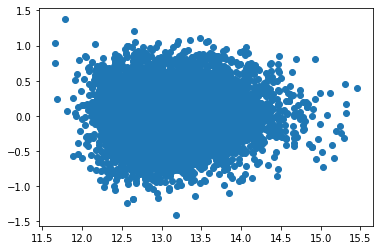

In [21]:
plt.scatter(y_hat_train, model.resid)
# plt.plot(y_hat_train(X_train[selected_columns])

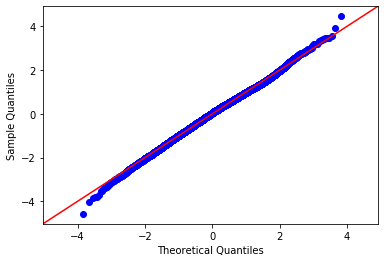

In [22]:
fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)

## Testing for Multicollinearity

In [23]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
X = X_fin
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
list(zip(X_fin, vif))

[('grade_6', 8.704348847986752),
 ('grade_10', 6.791008644835644),
 ('grade_7', 37.13121667556937),
 ('sqft_living15_log', 1459.0374730924532),
 ('sqft_living_log', 1170.5942501328332),
 ('yr_built_log', 1374.8979770655476),
 ('grade_11', 3.3804830271210027),
 ('sqft_lot_log', 147.12898252613314),
 ('grade_9', 13.272958103121738),
 ('grade_12', 1.5787590318343774),
 ('waterfront_1.0', 1.0443366692384843),
 ('floors_3.0', 1.29425910125208),
 ('bedrooms_2', 1.5118524484818638),
 ('grade_13', 1.0868508214816257),
 ('condition_5', 1.204538537250771),
 ('grade_8', 27.20618664121825),
 ('sale_month_4', 1.1318417502648668),
 ('condition_2', 1.0338355947051383),
 ('sale_month_3', 1.1090988627073388),
 ('bedrooms_4', 1.803306375400854),
 ('floors_2.0', 2.800796493509994),
 ('yrs_renovated_66.0', 1.0010829036438262),
 ('yrs_renovated_13.0', 1.0041107970395684),
 ('condition_4', 1.5789903389248277),
 ('yrs_renovated_10.0', 1.0018616473836257),
 ('floors_1.5', 1.218139627521191),
 ('yrs_renovated_

- Some of the features are displaying multicollinearity but droping them would lower the r squared even lower then it already is.

## OLS
- Running OLS Again to see how well it runs on the test data

In [24]:
X_fin = X_test[selected_columns]
X_with_intercept = sm.add_constant(X_fin)
model = sm.OLS(y_test,X_with_intercept).fit()
model.summary()

C:\Users\eduar\anaconda3\envs\learn-env\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.663
Model:                            OLS   Adj. R-squared:                  0.660
Method:                 Least Squares   F-statistic:                     258.4
Date:                Tue, 03 Nov 2020   Prob (F-statistic):               0.00
Time:                        10:55:16   Log-Likelihood:                -838.10
No. Observations:                3844   AIC:                             1736.
Df Residuals:                    3814   BIC:                             1924.
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 87.1723      3.471     25.117      0.000      80.368      93.977
grade_6                0.1637      0.048      3.441      0.001       0.070       0.257
grade_10               1.0443      0.056     18.542      0.000       0.934       1.155
grade_7                0.3881      0.047      8.259      0.000       0.296       0.480
sqft_living15_log      0.2497      0.025     10.167      0.000       0.202       0.298
sqft_living_log        0.4753      0.022     21.327      0.000       0.432       0.519
yr_built_log         -10.5049      0.459    -22.908      0.000     -11.404      -9.606
grade_11               1.1283      0.069     16.414      0.000       0.994       1.263
sqft_lot_log          -0.0550      0.007     -8.427      0.000      -0.068      -0.042
grade_9                0.8467      0.053     16.117      0.000       0.744       0.950
grade_12               1.4495      0.096     15.108      0.000       1.261       1.638
waterfront_1.0         0.4683      0.058      8.105      0.000       0.355       0.582
floors_3.0             0.2423      0.034      7.200      0.000       0.176       0.308
bedrooms_2             0.1344      0.017      7.867      0.000       0.101       0.168
grade_13               2.0189      0.148     13.645      0.000       1.729       2.309
condition_5            0.1100      0.020      5.458      0.000       0.071       0.150
grade_8                0.6036      0.049     12.284      0.000       0.507       0.700
sale_month_4           0.0930      0.016      5.740      0.000       0.061       0.125
condition_2           -0.1856      0.059     -3.126      0.002      -0.302      -0.069
sale_month_3           0.0479      0.018      2.728      0.006       0.013       0.082
bedrooms_4            -0.0320      0.012     -2.749      0.006      -0.055      -0.009
floors_2.0             0.0103      0.014      0.758      0.449      -0.016       0.037
yrs_renovated_66.0   2.58e-16   7.06e-17      3.657      0.000     1.2e-16    3.96e-16
yrs_renovated_13.0     0.2155      0.175      1.230      0.219      -0.128       0.559
condition_4            0.0361      0.012      2.943      0.003       0.012       0.060
yrs_renovated_10.0     0.1559      0.152      1.029      0.304      -0.141       0.453
floors_1.5             0.0349      0.019      1.851      0.064      -0.002       0.072
yrs_renovated_18.0    -0.1297      0.214     -0.605      0.545      -0.550       0.290
yrs_renovated_6.0      0.1240      0.096      1.291      0.197      -0.064       0.312
yrs_renovated_14.0     0.0023      0.214      0.011      0.992      -0.418       0.423
yrs_renovated_25.0    -0.1486      0.152     -0.977      0.329      -0.447       0.150
==============================================================================
Omnibus:                       21.634   Durbin

- This model fits the data much better then the previous model with zipcodes

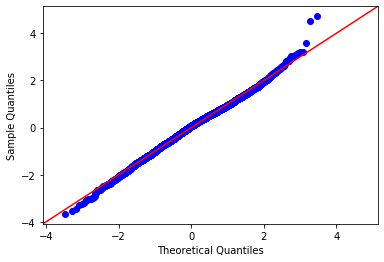

In [25]:
fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)

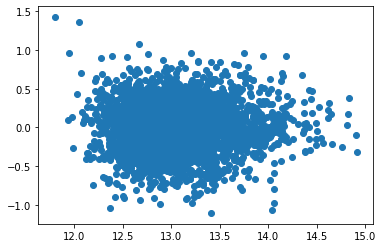

In [26]:
plt.scatter(y_hat_test, model.resid)

In [27]:
y_test.shape

(3844,)

- Regression Analysis and Diagnostics for price_log~grade_6
-------------------------------------------------------------------------------------


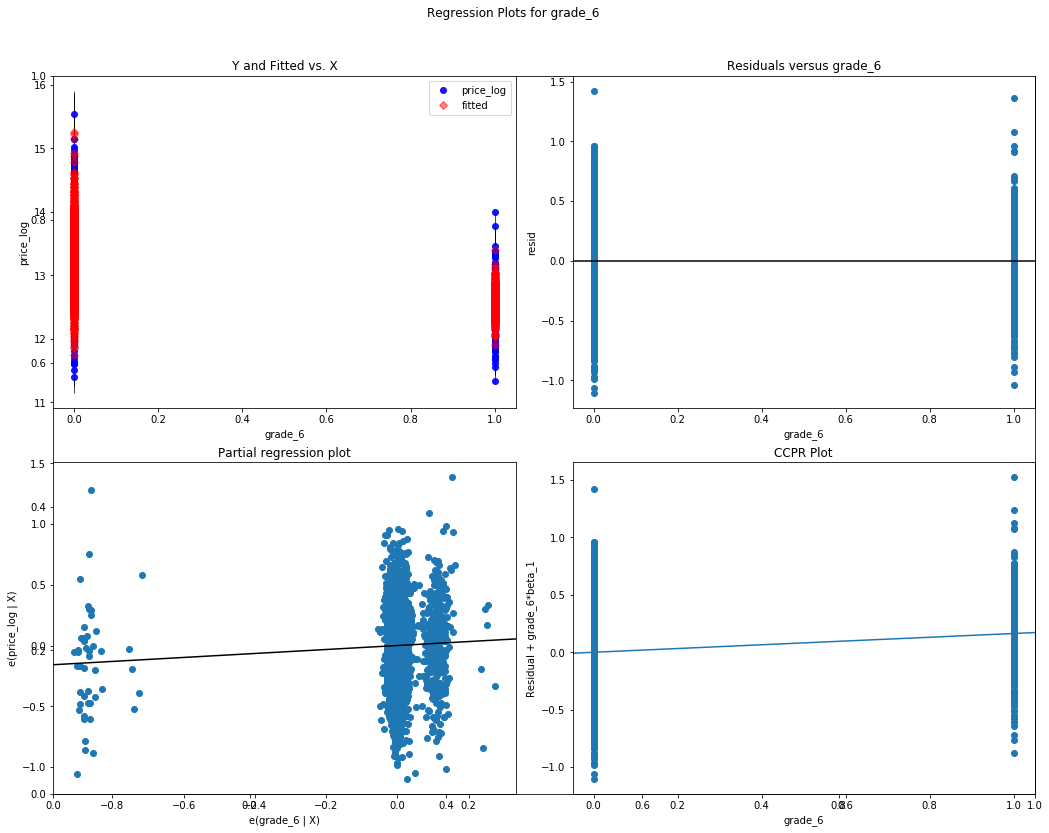

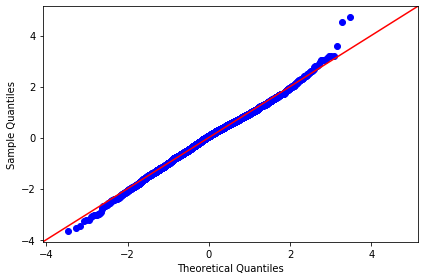

Press Enter to continue...
- Regression Analysis and Diagnostics for price_log~grade_10
-------------------------------------------------------------------------------------


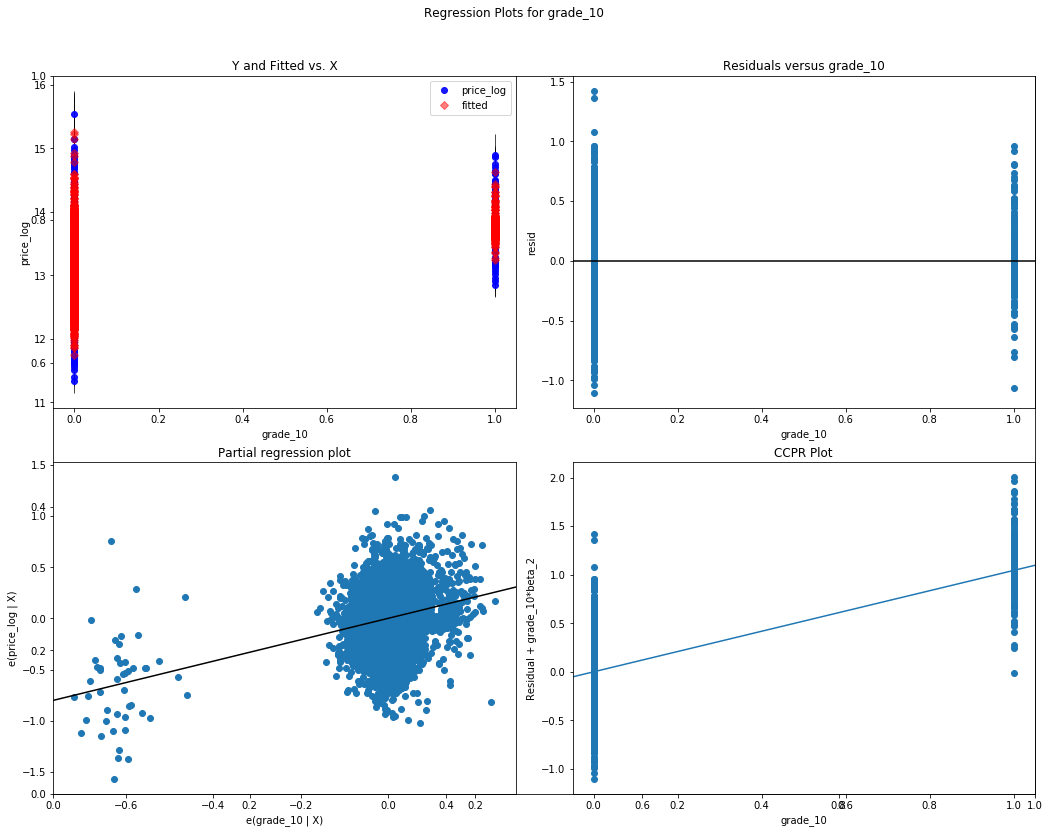

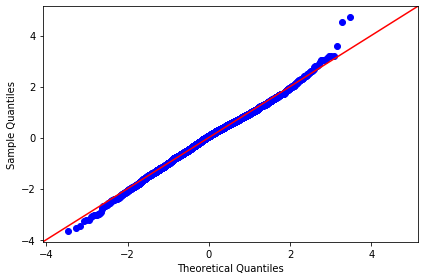

Press Enter to continue...
- Regression Analysis and Diagnostics for price_log~grade_7
-------------------------------------------------------------------------------------


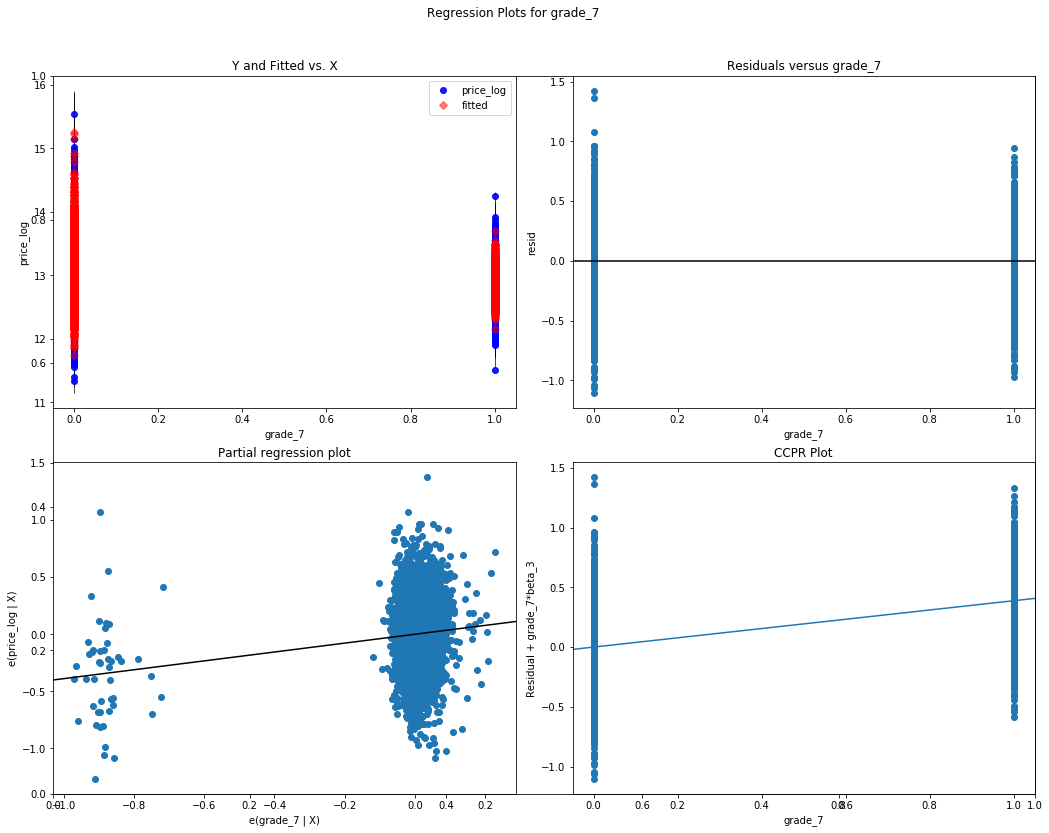

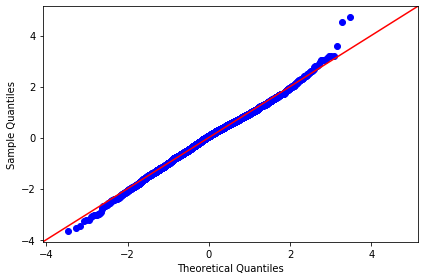

Press Enter to continue...
- Regression Analysis and Diagnostics for price_log~sqft_living15_log
-------------------------------------------------------------------------------------


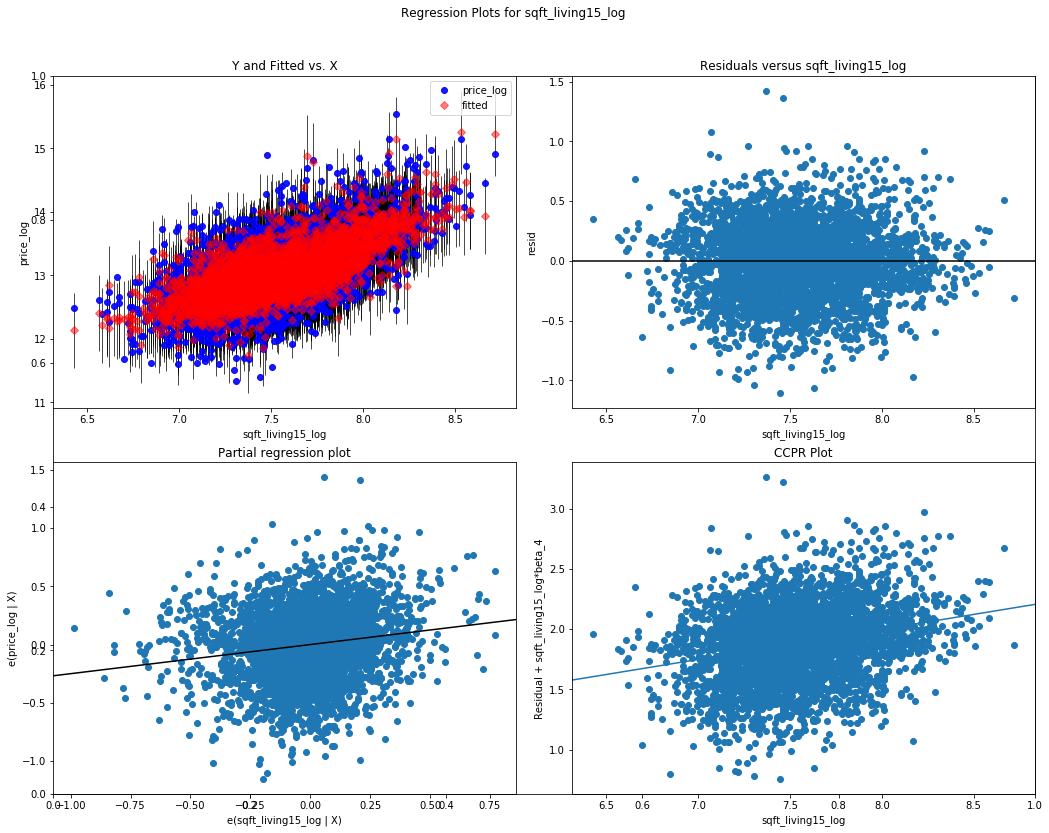

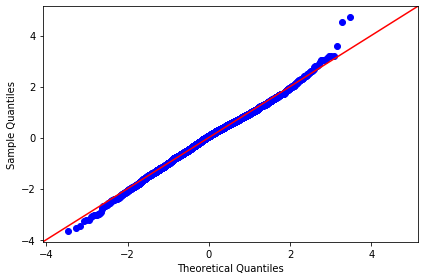

Press Enter to continue...
- Regression Analysis and Diagnostics for price_log~sqft_living_log
-------------------------------------------------------------------------------------


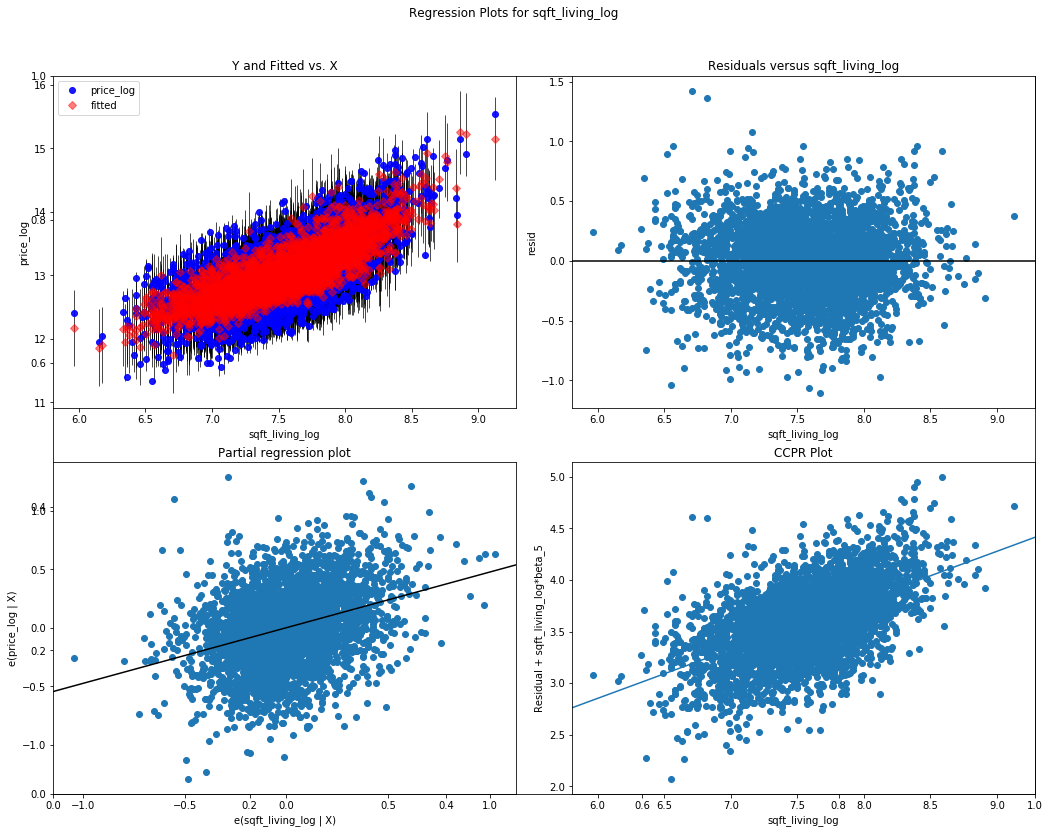

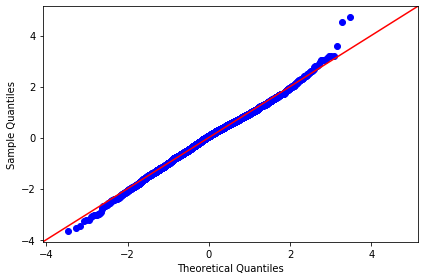

Press Enter to continue...
- Regression Analysis and Diagnostics for price_log~yr_built_log
-------------------------------------------------------------------------------------


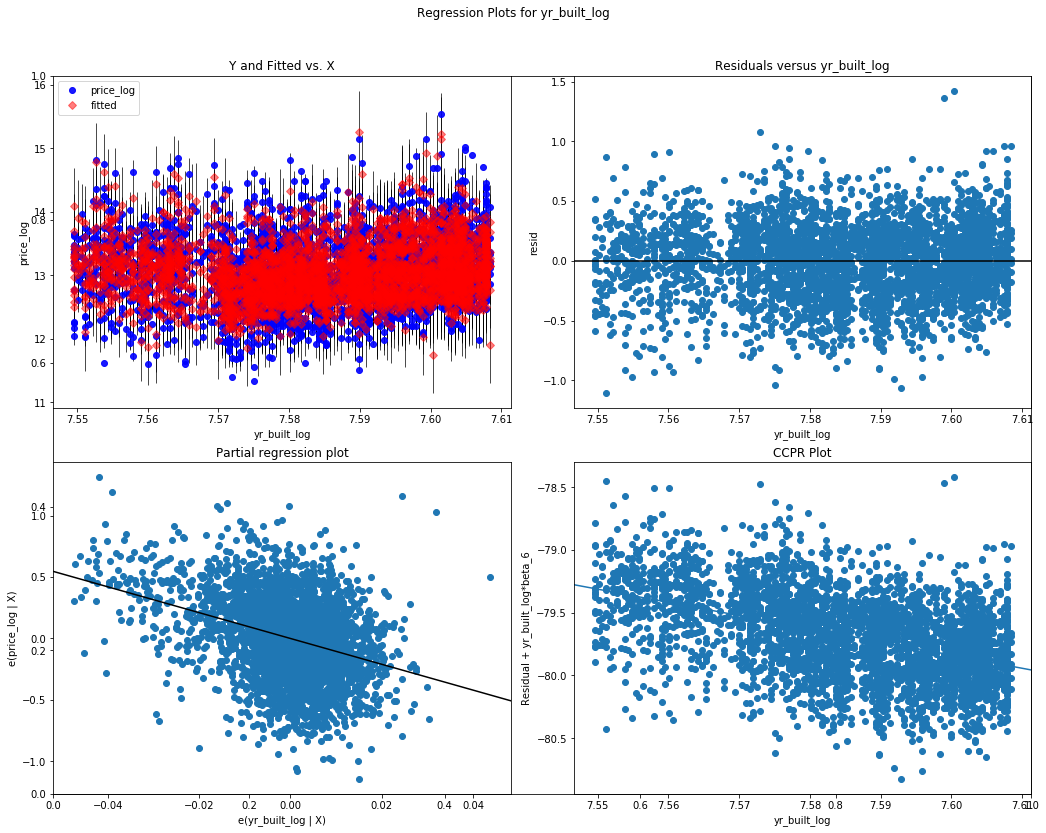

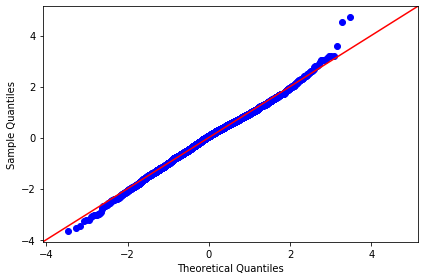

In [ ]:
import statsmodels.formula.api as smf
import scipy.stats as stats
import statsmodels.stats.api as sms

results = []
for idx, column in enumerate(X_fin):
    print (f"- Regression Analysis and Diagnostics for price_log~{column}")
    print ("-------------------------------------------------------------------------------------")
   

    f = f'price_log~{column}'
    model = sm.OLS(y_test,X_with_intercept).fit()
    
    fig, axes = plt.subplots(figsize=(15,12))
    fig = sm.graphics.plot_regress_exog(model, column, fig=fig)
    fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)
    fig.tight_layout()
    plt.show()
    
    results.append([column, model.rsquared, model.params[0], model.params[1], model.pvalues[1], sms.jarque_bera(model.resid)[0]])
    input("Press Enter to continue...")